# This notebook is purely for re-sampling and pre-processing audio input into *tensors*

### It implements this idea:
Files are originally at 44.1 kHz. They were resampled at 32 kHz and then trimmed based on the average energy of each window of the input signal. If it is below 25% of the total average energy and the post trimmed signal isn't smaller than the minimum audio size, then and only then we'll remove the entire data points in the window from the original signal. 

In [1]:
import librosa
import librosa.display
import soundfile
import matplotlib.pyplot as plt
import numpy as np
import torch

/home/nlpt4239/miniconda3/envs/SincNet/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


### Opening the directories of au files:

In [2]:
# Setting the original audio paths:
dir_audio_train = "/data2/dcase2018/task2/FSDKaggle2018.audio_train/"

# Setting the original audio paths:
dir_audio_test = "/data2/dcase2018/task2/FSDKaggle2018.audio_test/"

# Setting the targetted Sampling Rate:
targetSamplingRate = 32000


## This code is from Calot's nnaudio:
# to get the names of the .wav files in the folder
from os import listdir
from os.path import isfile, join
trainAudioFiles = [f for f in listdir(dir_audio_train) if isfile(join(dir_audio_train, f))]
testAudioFiles = [f for f in listdir(dir_audio_test) if isfile(join(dir_audio_test, f))]


In [3]:
print(len(trainAudioFiles))
print(len(testAudioFiles))

9473
1600


#### Saving file lists:

In [4]:
saving_test_files = False
saving_to_tensor  = False
saving_to_wav     = False

if saving_test_files:
        
    if saving_to_tensor:
        testTensorFiles = []
        for file in testAudioFiles:
            testTensorFiles.append(file.split(".")[0]+".pt")
        
        np.save("data_lists/Tensor_Test_list.npy", testTensorFiles)
        
    if saving_to_wav:
        np.save("data_lists/Audio_Test_list.npy", testAudioFiles)
    
    
    

### Loading sample of Originial Audio Files:

In [5]:
#showcasedAudioFile = dir_audio_train + "/" + trainAudioFiles[0]
showcasedAudioFile = dir_audio_train + "00ce569f.wav"# 00ce569f.wav is Hi-hat

signal, SamplingRate = librosa.load(showcasedAudioFile,  sr=targetSamplingRate)

SamplingRate

32000

#### Defining Plot function:

In [6]:
def plotImg(audio, samplingRate, ylabel = "Amplitude"):
    librosa.display.waveplot(audio, sr=samplingRate)
    plt.ylabel(ylabel)
    plt.title('Amplitude envelope of a waveform')
    plt.show()



#### Plotting Example:

Showcased audio file : /data2/dcase2018/task2/FSDKaggle2018.audio_train/00ce569f.wav



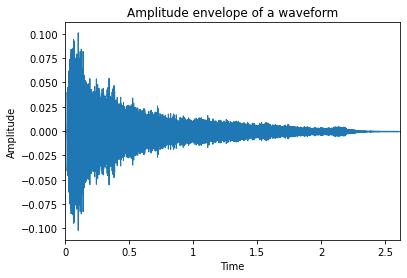

Sample rate is equal to 32000


In [7]:

print("Showcased audio file : " + showcasedAudioFile + "\n")

plotImg(signal, SamplingRate)
print("Sample rate is equal to {}".format(SamplingRate))


### Ideas For pre-processing improvements:

1. **Trim the fat:** basically removing silences in the beginning and the and of the audio files.
    1. Based on amplitude.
    2. Based on energy.
2. **Normalize** the amp of the signal.

#### Based on Amplitude:

296 43209 83840
[-3.1393800e-05 -1.5193672e-04 -9.7265329e-06 ...  2.9563143e-05
  9.4316592e-06 -2.5014986e-06]
[-0.00157735  0.00026247 -0.00184507 ...  0.09656452  0.10225112
  0.0224669 ]


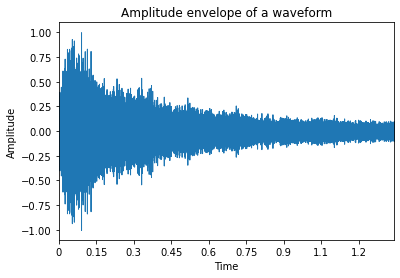

In [8]:
def Normalization(signal):
    return signal/np.max(np.abs(signal))

def TrimTheFat(signal, window_length = 200, samplingRate=32000, delay=10, threshold = 0, 
               repeat_signal = False, printInterval = True): 
    # Is the size of the window of SincNet:
    minAudioSize = samplingRate *window_length /1000
    
    size = len(signal)
    
    ## Pad if audio is not long enough:
    ## Todo padding right and left equally!
    if(size < minAudioSize):
        
        nbre_zeros_gauche = int((minAudioSize - size)/2 + (minAudioSize - size)%2)
        nbre_zeros_droite = int((minAudioSize - size)/2)
        
        return np.pad(np.append(np.zeros(nbre_zeros_gauche), signal), (0, nbre_zeros_droite), 'constant')
        
        return np.pad(signal, (0, abs(int(minAudioSize - size))), 'constant')
    
    
    ## <!>----------------------- Trimming begins here -----------------------<!> ##
    begin, end = (0, size-1)    

    for i, el in enumerate(signal[::-1]):
        if(abs(end-begin) <= minAudioSize+1):
            break
        
        end = size - i

        if(el > threshold):
            break

    
    for i, el in enumerate(signal):
        ## We can define a threshold after normalization, ex: el <= 1.e-5
        if(abs(end-begin) <= minAudioSize+1):
            break
            
        begin = max(i-delay, 0)
        
        if(el > threshold):
            break
    
    
    ## For visualization only:
    if(printInterval):print(begin, end, size)
    
    return signal[begin:end+1]
    


processed_signal = TrimTheFat(Normalization(signal), samplingRate=32000, delay=20, threshold = 1.e-1)

print(signal)
print(processed_signal)
plotImg(processed_signal, SamplingRate)

#### Based on Energy:

Formula is :
    $$E_x = \cfrac{1}{L}\Sigma_{n=0}^{L} |x[n]|^2 $$

In [9]:
def EnergyWindowMean(audio, L=300, stride=150, padding = False, removingZeros = False, debug_mode = False):
    N = len(audio)
    
    ## Just for display purposes, removes
    if(debug_mode):print(N)
    
    ## Adds padding if it is requested:
    if(padding):
        
        if((N - L)%stride != 0):
            for i in range (0, stride - (N - L)%stride):
                audio = np.append(audio, 0)
                
        ## Computes the new length after padding 
        N = len(audio)
        
        if(debug_mode):print(N-L, N)
    
    
    ## <!>--------- Computes the enrgy Here ---------<!> ##
    
    # Initializes the energy array
    #np.array([sum([el*el for el in audio[i:i+L]])/L  for i in (0, (N - L), stride)])
    Energy = np.zeros(int((N-L)/stride) + 1)
    
    ## Very important +1 is needed for i to be equal to (N - L)!
    for i in range(0, (N - L + 1), stride):
        E = 0
        for j in range (i, i + L):
            E += audio[j]*audio[j]
            
        E /= L
        
        Energy[int(i/stride)] = E

    ## <!>------------------- Done -------------------<!> ##

    if(removingZeros):
        ## Removing zeros from energy:
        for i in range (len(Energy)-1, -1, -1):
            if(Energy[i] > 0):
                Energy = Energy[:i+1]
                break
    
    if(debug_mode):
        print(len(Energy))
        
        string_pad = "with padding" if padding else "without padding"
        
        print("Expected length of the array " + string_pad + " : " + str(int((N-L)/stride) + 1))
    
    return Energy

83840
83400 84000
279
Expected length of the array with padding : 279


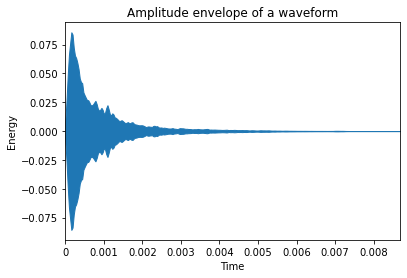

Signals energy mean is 0.006357080170356197


In [10]:
plotImg(EnergyWindowMean(Normalization(signal), L=600, stride=300, padding = True, debug_mode = True), SamplingRate, ylabel='Energy')

Energy_Mean = sum([el*el for el in Normalization(signal)])/len(signal)
print("Signals energy mean is {}".format(Energy_Mean))

#### Energy Trim function:

In [11]:
## Faire le trimming avec l'energy

# @threshold is in percentage. Here it is set by default to 5, meaning that it cuts the signal if the energy is below 5%.
def TrimEnergy(audio,
               threshold=5,
               delay = 0,
               window_length = 200,
               samplingRate=32000,
               L=600, stride=300,
               padding = True,
               random_padding_zeros = False,
               repeating_signal = False,
               printInterval = False):
    
    # Is the size of the window of SincNet:
    minAudioSize = samplingRate *window_length /1000
    
    # We store the sieze of the audio file:
    size = len(audio)
    
    ## Computing the average energy of the signal:
    Energy_Mean = sum([el*el for el in audio])/size
    
    ## Computing the energy threshold:
    Energy_Threshold = Energy_Mean * threshold/100
    
    ## The Energy window: (It is the average energy of a window)
    Energy = EnergyWindowMean(audio, L, stride, padding = padding, debug_mode = printInterval)
    
    #print(Energy_Mean, Energy_Threshold, Energy[:100])
    
    
    ## Pads with 0s if audio is not long enough:
    if(size < minAudioSize):
        if(repeating_signal):
            
            ## We continue to add values till the signal is at required window size, resulting into a repeated signal:
            i=0
            while(size < minAudioSize):
                audio = np.append(audio, audio[i])
                
                ## Updates the size, is basically a size+=1 but for correctness is written like this.
                size = len(audio)
                i+=1
                
            return audio
        
        elif(random_padding_zeros):
            
            number_of_zeros_added = minAudioSize - size
            nbre_zeros_gauche     = int(np.random.randint(0, number_of_zeros_added))
            nbre_zeros_droite     = int(number_of_zeros_added - nbre_zeros_gauche)
            
            #print("The number of zeros to the left is {}".format(nbre_zeros_gauche))
            
            return np.pad(np.append(np.zeros(nbre_zeros_gauche), audio), (0, nbre_zeros_droite), 'constant')
        
        else:
            ## New version that pads to the right and the left equally:
            nbre_zeros_gauche = int((minAudioSize - size)/2 + (minAudioSize - size)%2)
            nbre_zeros_droite = int((minAudioSize - size)/2)

            return np.pad(np.append(np.zeros(nbre_zeros_gauche), audio), (0, nbre_zeros_droite), 'constant')
        
            ## Pads everything to the right:
            #return np.pad(audio, (0, abs(int(minAudioSize - size))), 'constant')
        
    elif(size == minAudioSize):
        return audio
    
    
    ## <!>----------------------- Trimming begins here -----------------------<!> ##
    begin, end = (0, size-1)
    
    ## Time complexity is O(size/stride), way better than TrimTheFat
    for i in range(0, size, stride):
        ChangedPostition = False
        
        if(Energy[int(-i/stride) -1] <= Energy_Threshold):
            end = size - i
            ChangedPostition= True
            
        
        # Left pos is an anchor, once it finds the right pos it doesn't move anymore, right can if we change the last if.
        if(Energy[int(begin/stride)] <= Energy_Threshold):
            begin = i
            ChangedPostition= True
        
        
        # Because of the stride, sometimes we remove more then we would like to...
        if(end-begin <= minAudioSize):
            ## We add reamining points from right to left
            remaining_points_to_add = minAudioSize - (end - begin)#remaining_points_to_add in theory is < 2 * stride !
            
            ## We compute the number of points to add:
            nbre_points_left  = int((remaining_points_to_add)/2 + remaining_points_to_add%2)
            nbre_points_right = int((remaining_points_to_add)/2)
            
            ## We add to the right the number of points we couldn't add to the left:
            nbre_points_right += nbre_points_left - (begin - max(begin - nbre_points_left, 0))
            
            ## Updating iterators:
            begin = max(begin - nbre_points_left, 0)
            end   += nbre_points_right
        
            break
        
        ## If the positions of the trim do not change, then it means that we finished the trimming! 
        ## We can change that if we wish to 
        if(not ChangedPostition):
            break
    
    ## For visualization only:
    if(printInterval):
        print(begin, end, size)
        print("Resulting size is : {}".format(end-begin))
    
    if(delay != 0):
        begin = max(begin-delay, 0)
        
    ## For visualization only:
    if(printInterval):
        print("Last interval print, after the Trim: [{0}, {1}] of original size {2}.".format(begin, end, size))
        if(end-begin < minAudioSize):
            print("Houston - we have a problem.")
    
    ## We take one more point in case !
    return audio[begin:end+1]
    

83840
83400 84000
279
Expected length of the array with padding : 279
0 36140 83840
Resulting size is : 36140
Last interval print, after the Trim: [0, 36140] of original size 83840.


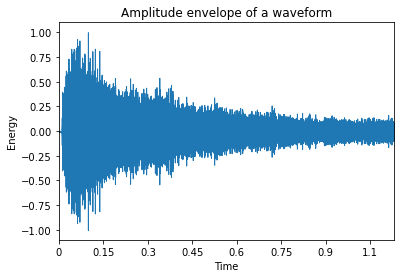

In [12]:
## 25% seems doing the most work.
plotImg(TrimEnergy(Normalization(signal), threshold=25, delay = 3200, window_length = 1000, samplingRate=32000, L=600, stride=300, random_padding_zeros = False, printInterval = True), SamplingRate, ylabel='Energy')

### Applying these ideas and creating a new dataset:

#### Fetching and storing info on data:

In [13]:
## Functions that do so:
dict_of_audio_length_before = {}
dict_of_audio_length_after  = {}

def Store(dictionary, value):
    if(value in dictionary.keys()):
        dictionary[value] += 1
    else:
        dictionary[value] = 1
        
    return dictionary

In [14]:
## Save dictionaries:
def Storing_Data(storing_data = False):
    if(storing_data):
        np.save("data_lists/Dictionary_of_original_audio_length.npy", dict_of_audio_length_before)
        np.save("data_lists/Dictionary_of_audio_length_after_preprocessing.npy", dict_of_audio_length_after)

#### Defining the preprocessing function:

In [15]:
def preprocess(targetSamplingRate,
               AudioFiles,
               path_to_load,
               path_to_save,
               window_length,
               threshold_percentage = 0,
               L=600,# User should not worry about stride and Energy size.
               stride = 300,
               threshold = 0,
               delay = 0,# By default it is 0 because if user does not specify a delay we should not add one.
               TrimWithEnergy = True,
               padding = True,
               random_padding_zeros = False,
               repeating_signal = False,
               path_to_save_audio = None,
               writing_audio = False,
               storing_data = False):
    
    ## Removes user error:
    if(TrimWithEnergy and threshold_percentage==0):
        print("Please set a value for the threshold_percentage var.")
        return -1
    elif(not TrimWithEnergy and threshold==0):
        print("Please set a value for the threshold var.")
        return -1
    
   
    
    
    for i, filename in enumerate(AudioFiles):

        train_audio, _ = librosa.load(path_to_load + "/" + filename,  sr=targetSamplingRate)

        
        ## Shows the delay
        if(i == 0):
            print("In the following preprocessing, the delay is equal to {}ms.".format(delay / targetSamplingRate * 1000))
            print("\n")

        ## Storing audio lengths before preprocessing in dict:
        if(storing_data):
            length_before = len(train_audio)/targetSamplingRate
            dict_of_audio_length_before = Store(dict_of_audio_length_before, length_before)


        ## Prints the first 10 audio files:
        printInterval = i<10

        ## We use the preprocessing algorithms use above:
        if(TrimWithEnergy):
            preprocessedTrainAudio = TrimEnergy(Normalization(train_audio),
                                                threshold = threshold_percentage,
                                                delay=delay,
                                                window_length = window_length,
                                                samplingRate = targetSamplingRate,
                                                L=L,
                                                stride=stride,
                                                padding = padding,
                                                random_padding_zeros = random_padding_zeros,
                                                repeating_signal = repeating_signal,
                                                printInterval = printInterval)
        else:
            preprocessedTrainAudio = TrimTheFat(Normalization(train_audio),
                                                window_length=window_length, 
                                                samplingRate=targetSamplingRate,
                                                delay=delay,
                                                threshold = threshold,
                                                printInterval=printInterval)
            
            

        ## Storing audio lengths after preprocessing in dict:        
        if(storing_data):
            length_after = len(train_audio)/targetSamplingRate
            dict_of_audio_length_before = Store(dict_of_audio_length_after, length_after)

            
        ## Saving audio files if requested:        
        if(writing_audio):
            soundfile.write(path_to_save_audio + "/" + filename, data=preprocessedTrainAudio, samplerate=targetSamplingRate)
        
        ## Stores the audio in a tensor
        temp_t = torch.tensor(preprocessedTrainAudio).float()
        
        ## Solves new name for tensor
        new_name = filename.split(".")[0] + ".pt"
        
        ## Saves the tensor to path
        torch.save(temp_t, path_to_save + new_name)
    
        if(i<10):
            plotImg(preprocessedTrainAudio, targetSamplingRate)

        # The ausio size is desired to be of size at least targetSamplingRate * window_length/ 1000
        if(len(preprocessedTrainAudio) < targetSamplingRate *window_length /1000):
            print('audio sample {0} is too small ! His length is equal to {1}'.format(filename, len(preprocessedTrainAudio)))
            break

    print("Pre-processing is done !")
    print("Wrote in the " + path_to_save + " folder!")
    


#### Preprocessing on Amplitude:

In [16]:
## Do not run if already executed before
path_to_save = "Data/Audio_Tensors/Train/Preprocessed_audio_Window1000ms/"



## Parameters of the trim:
window_length = 1000#ms
delay = 20#values
threshold = 1.e-1
storing_data = False

## Uncomment this if you want to preprocess with amps:
'''preprocess(trainAudioFiles,
               writingDirAudioTrain,
               writingDirAudioTrain_2,
               window_length,
               threshold = threshold,
               delay = delay,# By default it is 0 because if user does not specify a delay we should not add one.
               TrimWithEnergy = False,
               storing_data = storing_data)

Storing_Data(storing_data)
'''


'preprocess(trainAudioFiles,\n               writingDirAudioTrain,\n               writingDirAudioTrain_2,\n               window_length,\n               threshold = threshold,\n               delay = delay,# By default it is 0 because if user does not specify a delay we should not add one.\n               TrimWithEnergy = False,\n               storing_data = storing_data)\n\nStoring_Data(storing_data)\n'

#### Preprocessing train audio on Energy:

In the following preprocessing, the delay is equal to 10.0ms.


51200
50700 51300
170
Expected length of the array with padding : 170


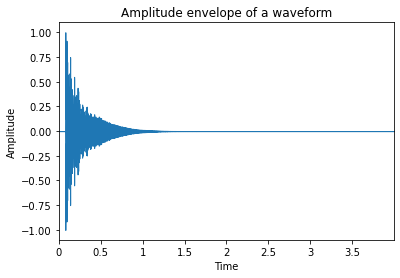

10240
9900 10500
34
Expected length of the array with padding : 34


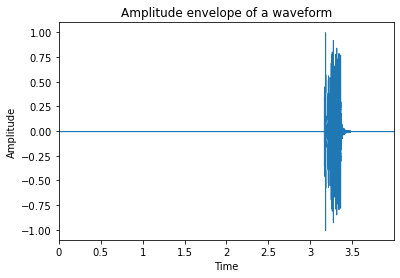

79360
78900 79500
264
Expected length of the array with padding : 264


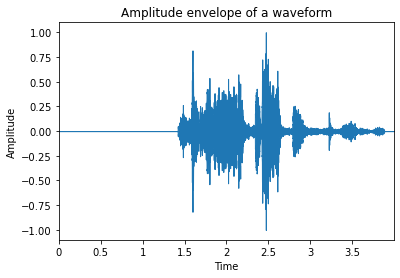

525440
525000 525600
1751
Expected length of the array with padding : 1751
900 512540 525440
Resulting size is : 511640
Last interval print, after the Trim: [580, 512540] of original size 525440.


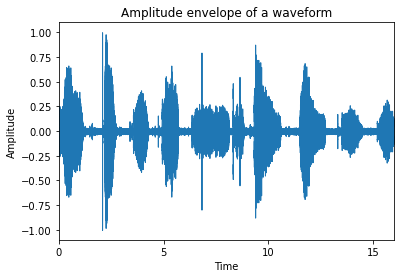

271360
270900 271500
904
Expected length of the array with padding : 904
71680 199680 271360
Resulting size is : 128000
Last interval print, after the Trim: [71360, 199680] of original size 271360.


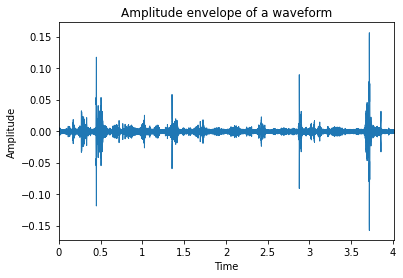

15360
15000 15600
51
Expected length of the array with padding : 51


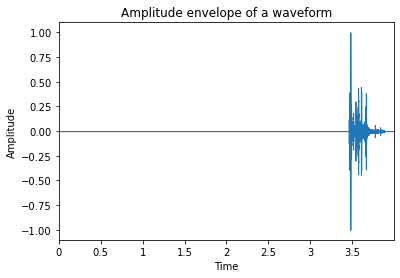

136960
136500 137100
456
Expected length of the array with padding : 456
1200 132460 136960
Resulting size is : 131260
Last interval print, after the Trim: [880, 132460] of original size 136960.


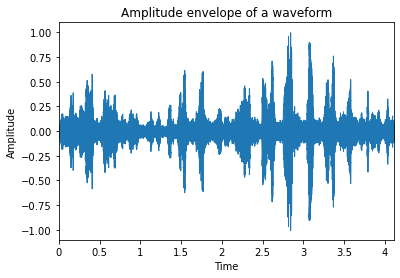

349440
348900 349500
1164
Expected length of the array with padding : 1164
2400 324840 349440
Resulting size is : 322440
Last interval print, after the Trim: [2080, 324840] of original size 349440.


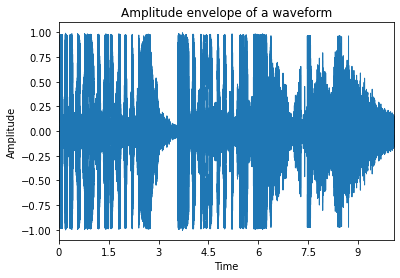

59520
59100 59700
198
Expected length of the array with padding : 198


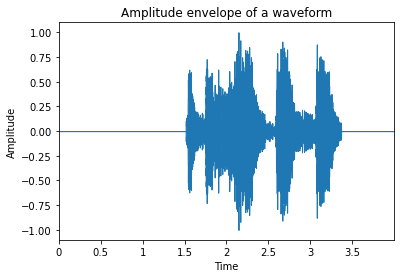

534400
534000 534600
1781
Expected length of the array with padding : 1781
2100 522100 534400
Resulting size is : 520000
Last interval print, after the Trim: [1780, 522100] of original size 534400.


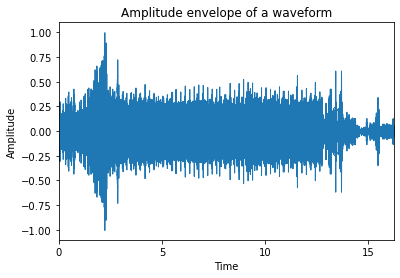

Pre-processing is done !
Wrote in the Data/Audio_Tensors/Train/Preprocessed_withEnergy_AudioTensors_Window4000ms_Random0Padding/ folder!


In [17]:
## <!>------------- Here we are trimming based on energy! -------------<!> ##
TrimWithEnergy = True

## Path to write Tensors:
writingDirAudioTrain_Tensors_3 = "Data/Audio_Tensors/Train/Preprocessed_withEnergy_AudioTensors_Window4000ms_Random0Padding/"

## Parameters used to read audio files:
targetSamplingRate = 32000
trainAudioFiles
dir_audio_train

## Parameters of the trim:
window_length = 4000#ms
threshold_percentage = 25#%
L = 600#values
stride = 300#values
delay = 320 #values
padding = True
random_padding_zeros = True
repeating_signal = False
storing_data = False

## Parameter used to store audio files:
writingDirAudioTrain_3 = "Data/Audio_Files/NeedToCreateDir"
writing_audio = False

preprocess(targetSamplingRate,
           trainAudioFiles,
           dir_audio_train,
           writingDirAudioTrain_Tensors_3,
           window_length,
           threshold_percentage = threshold_percentage,
           L=L,
           stride = stride,
           delay = delay,
           TrimWithEnergy = TrimWithEnergy,
           padding = padding,
           random_padding_zeros = random_padding_zeros,
           repeating_signal = repeating_signal,
           path_to_save_audio = writingDirAudioTrain_3,
           writing_audio = writing_audio,
           storing_data = storing_data)

Storing_Data(storing_data)

#### Preprocessing test audio on Energy:

In the following preprocessing, the delay is equal to 10.0ms.


33280
32700 33300
110
Expected length of the array with padding : 110


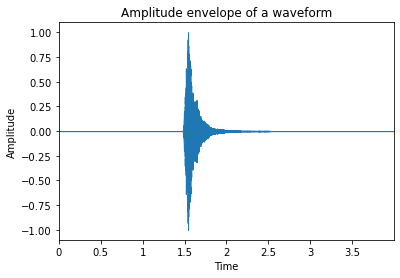

128000
127500 128100
426
Expected length of the array with padding : 426


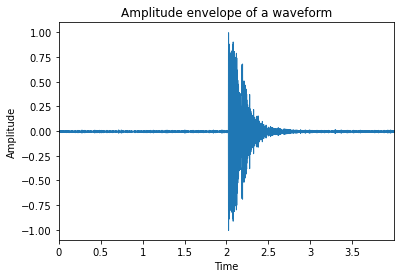

172800
172200 172800
575
Expected length of the array with padding : 575
16200 154800 172800
Resulting size is : 138600
Last interval print, after the Trim: [15880, 154800] of original size 172800.


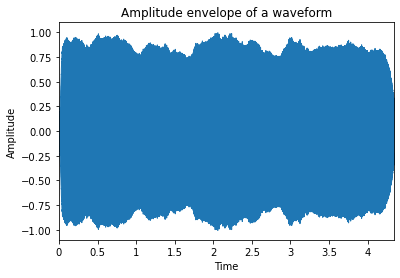

231040
230700 231300
770
Expected length of the array with padding : 770
0 128000 231040
Resulting size is : 128000
Last interval print, after the Trim: [0, 128000] of original size 231040.


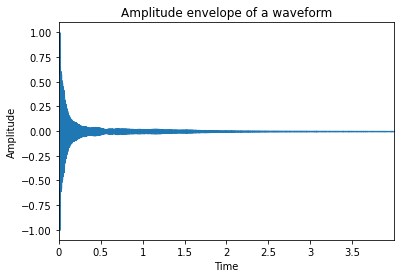

427520
427200 427800
1425
Expected length of the array with padding : 1425
0 374120 427520
Resulting size is : 374120
Last interval print, after the Trim: [0, 374120] of original size 427520.


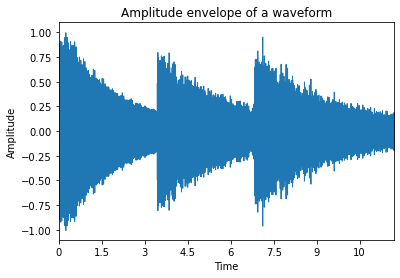

55040
54600 55200
183
Expected length of the array with padding : 183


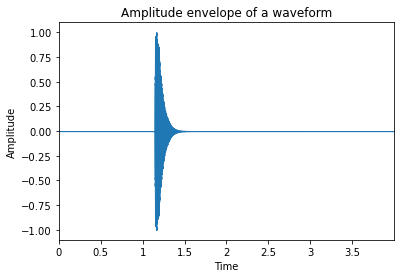

26880
26400 27000
89
Expected length of the array with padding : 89


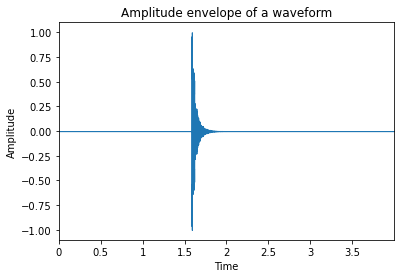

280960
280500 281100
936
Expected length of the array with padding : 936
2700 232360 280960
Resulting size is : 229660
Last interval print, after the Trim: [2380, 232360] of original size 280960.


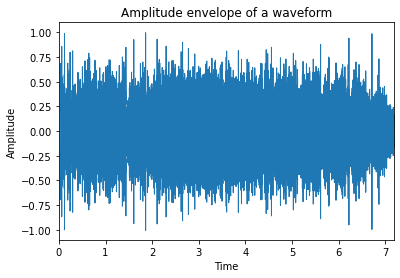

302080
301500 302100
1006
Expected length of the array with padding : 1006
30000 266980 302080
Resulting size is : 236980
Last interval print, after the Trim: [29680, 266980] of original size 302080.


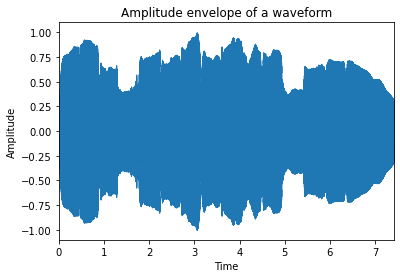

16000
15600 16200
53
Expected length of the array with padding : 53


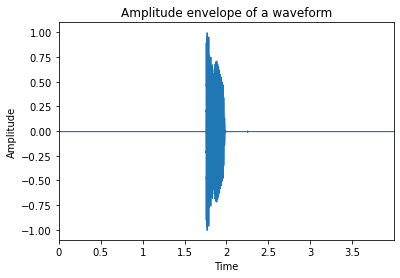

Pre-processing is done !
Wrote in the Data/Audio_Tensors/Test/Preprocessed_withEnergy_AudioTensors_Window4000ms_Random0Padding/ folder!


In [18]:
writingDirAudioTrain_Tensors_3 = "Data/Audio_Tensors/Test/Preprocessed_withEnergy_AudioTensors_Window4000ms_Random0Padding/"

## Parameters used to read audio files:
targetSamplingRate = 32000
testAudioFiles
dir_audio_test

## Parameters of the trim:
window_length = 4000#ms
threshold_percentage = 25#%
L = 600#values
stride = 300#values
delay = 320 #values
padding = True
random_padding_zeros = True
repeating_signal = False
storing_data = False

## Parameter used to store audio files:
writingDirAudioTrain_3 = "Data/Audio_Files/NeedToCreateDir"
writing_audio = False

preprocess(targetSamplingRate,
           testAudioFiles,
           dir_audio_test,
           writingDirAudioTrain_Tensors_3,
           window_length,
           threshold_percentage = threshold_percentage,
           L=L,
           stride = stride,
           delay = delay,
           TrimWithEnergy = True,
           padding = padding,
           path_to_save_audio = writingDirAudioTrain_3,
           writing_audio = False,
           storing_data = storing_data)

Storing_Data(storing_data)

#### Plot audio lengths before and after:

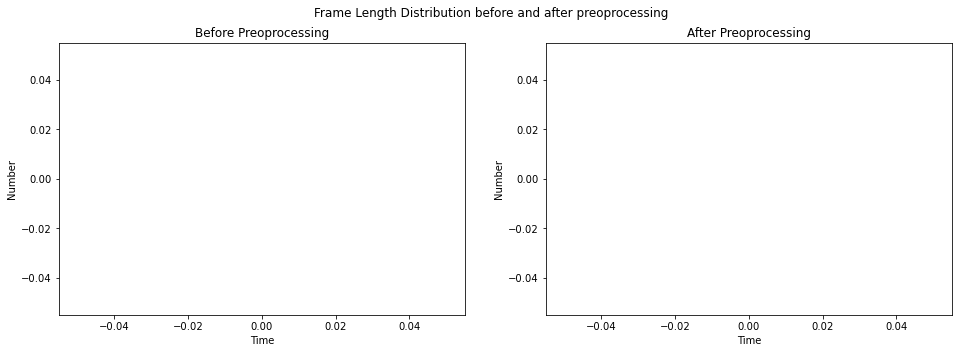

In [4]:
dict_of_audio_length_before = np.load("data_lists/Dictionary_of_original_audio_length.npy").item()
dict_of_audio_length_after  = np.load("data_lists/Dictionary_of_audio_length_after_preprocessing.npy").item()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

titles = ["Before Preoprocessing", "After Preoprocessing"]
dicts = [dict_of_audio_length_before, dict_of_audio_length_after]

for i, ax in enumerate(axes):
    ax.bar(dicts[i].keys(), dicts[i].values(), width=0.3, color='g')
    ax.set_xlabel("Time")
    ax.set_ylabel("Number")
    ax.set_title(titles[i])

plt.suptitle('Frame Length Distribution before and after preoprocessing', ha='center', fontsize='large');
plt.show()

In [5]:
count_avant_400 = 0
count_avant_600 = 0
count_avant_800 = 0
count_avant_1000 = 0

min_temps = min(dict_of_audio_length_before.keys())

for key, value in dict_of_audio_length_before.items():
    if  (key < 0.4):
        count_avant_400 += 1
    elif(key < 0.6):
        count_avant_600 += 1
    elif(key < 0.8):
        count_avant_800 += 1
    elif(key < 1.0):
        count_avant_1000 += 1

        
print(min_temps, count_avant_400, count_avant_600, count_avant_800, count_avant_1000)

ValueError: min() arg is an empty sequence